AUC AND RETURNS

author: [@sparshsah](https://github.com/sparshsah)

AUC is a very common measure of predictive goodness, and the direction of its relationship to returns is obvious. But, the shape and magnitude of that relationship isn't so obvious.

Below I demonstrate that the marginal payoff is linear, which honestly kind-of surprised me (?). And the magnitude isn't too shabby either (two points of AUC yield one point of ER), although this number will of course depend on the market setting you come up with.

In [146]:
from typing import Final

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

import foggy_statslib.core as fsc


PX_SURV: Final[float] = 1.30
PX_FAIL: Final[float] = 0.00

# cosmic background probability of survival is whatever makes the game actuarially fair
GODS_PSURV: Final[float] = (1 - PX_FAIL) / (PX_SURV - PX_FAIL)

PFLIO_SZ: Final[int] = 100_000

# see below... artificially inflates AUC
ORACLE_FACTOR: Final[float] = 0.05

RNG: Final[np.random.Generator] = np.random.default_rng(seed=42)


def _gen_px(
    psurv: float = GODS_PSURV,
) -> float:
    """Get terminal price, according to given survival probability."""
    if psurv < 0:
        raise ValueError(psurv)
    elif 0 <= psurv < ORACLE_FACTOR:
        px = PX_FAIL
    elif 0.05 <= psurv < 1 - ORACLE_FACTOR:
        if RNG.random() > psurv:
            px = PX_FAIL
        else:
            px = PX_SURV
    elif ORACLE_FACTOR <= psurv <= 1:
        px = PX_SURV
    else:
        raise ValueError(psurv)
    return px


def gen_one_px(
    our_psurv: float = GODS_PSURV,
    our_strength: float = 1,
) -> float:
    """Get terminal price.

    Args:
        our_psurv: float in [0, 1], survival as predicted by us.
        our_strength: float in [0, 1], "goodness" of predictions by us.
            Terminal price will be uniformly random with probability `1 - our_strength`.

    Returns:
        float, either PX_SURV or PX_FAIL.
    """
    our_px = _gen_px(psurv=our_psurv)
    gods_px = _gen_px()
    px = our_px if RNG.random() <= our_strength else gods_px
    return px


def gen_many_pxs_across_our_psurvs(
    our_strength: float = 1,
    sz: int = PFLIO_SZ,
) -> pd.Series:
    """Generate actual prices corresponding to a variety of predicted psurv's,
    holding constant the given predictive strength.
    """
    our_psurvs = pd.Index(
        np.linspace(0, 1, num=sz),
        name="our_psurvs",
    )
    return pd.Series(
        {
            our_psurv: gen_one_px(
                our_psurv=our_psurv,
                our_strength=our_strength,
            )
            for our_psurv in our_psurvs
        },
        index=our_psurvs,
    )


def gen_many_pxs_fixing_our_psurv(
    our_psurv: float = GODS_PSURV,
    our_strength: float = 1,
) -> pd.Series:
    """Simulate a trading session assuming we buy a bunch of stocks that look good to us,
    i.e. our model scores them as `our_psurv`.
    """
    tickers = pd.Index(
        range(PFLIO_SZ),
        name="ticker",
    )
    return pd.Series(
        {
            ticker: gen_one_px(
                our_psurv=our_psurv,
                our_strength=our_strength,
            )
            for ticker in tickers
        },
        index=tickers,
    )


def est_auc(our_strength: float = 1) -> float:
    """Translate predictive "goodness" to ROC AUC, using a simulation-based approach.

    For example, if I tell you that my predictive goodness is 0.80,
    you know how to simulate returns, but that doesn't really answer our investigative question.
    """
    # Generate actual prices corresponding to a variety of predicted psurv's,
    # holding constant the given predictive strength.
    actual_px_by_our_psurv = gen_many_pxs_across_our_psurvs(our_strength=our_strength)
    # px's will be high when psurv's are high if our strength is good.
    # But, px's will look unrelated to psurv's if our strength is bad.
    auc = sklearn.metrics.roc_auc_score(
        # actual_px's
        y_true=list(
            # sklearn demands True's if survived else False's
            map(
                bool,
                actual_px_by_our_psurv.values,
            )
        ),
        # our_psurv's
        y_score=list(
            actual_px_by_our_psurv.index
        ),
    )
    return auc


def est_er(
    our_psurv: float = GODS_PSURV,
    our_strength: float = 1,
) -> float:
    """Translate predictive "goodness" to Expected Return, using a simulation-based approach."""
    pxs = gen_many_pxs_fixing_our_psurv(
        our_psurv=our_psurv,
        our_strength=our_strength,
    )
    rets = pxs / 1 - 1
    return rets.mean()

In [147]:
auc_by_strength = pd.Series(
    {
        our_strength: est_auc(our_strength=our_strength)
        for our_strength in np.linspace(0,1)
    },
    name="auc",
)

er_by_strength = pd.Series(
    {
        our_strength: est_er(
            our_psurv=0.90,
            our_strength=our_strength,
        )
        for our_strength in np.linspace(0,1)
    },
    name="er",
)

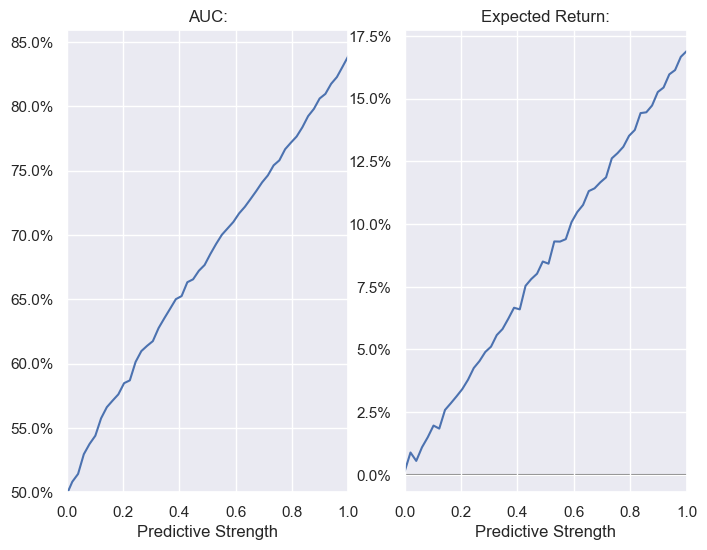

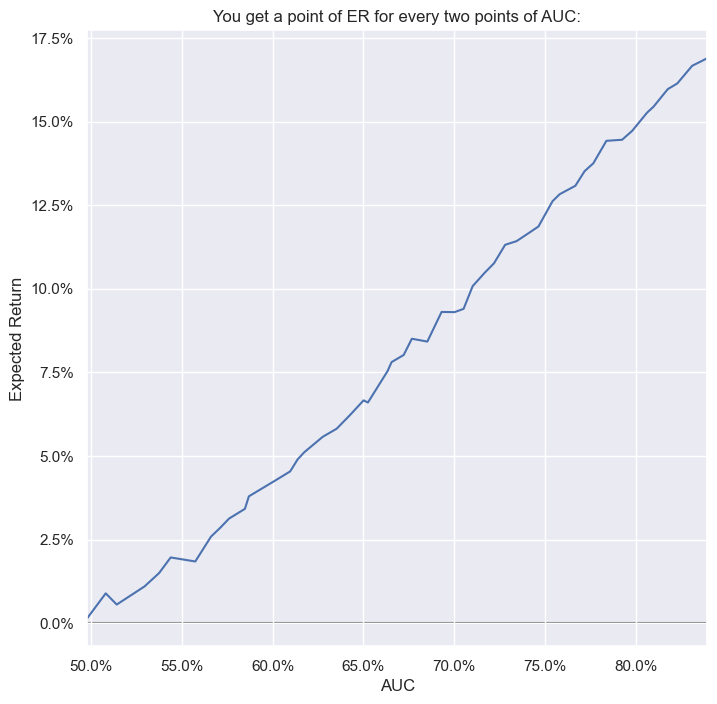

<Axes: title={'center': 'You get a point of ER for every two points of AUC:'}, xlabel='AUC', ylabel='Expected Return'>

In [149]:
_, ax = plt.subplots(ncols=2, sharex=True)

fsc.plot(
    auc_by_strength,

    xlim=[0,1],
    xlabel="Predictive Strength",

    axhline_locs=[0,0.45,1],
    axhline_styles=["-", "--", "-"],
    ylim=[0.50, auc_by_strength.max() + 0.02],
    ypct=True,
    title="AUC:",

    ax=ax[0],
)

fsc.plot(
    er_by_strength,

    xlim=[0,1],
    xlabel="Predictive Strength",

    ypct=True,
    title="Expected Return:",

    ax=ax[1],
    figsize=(8,6),
)

plt.show()


er_by_auc = pd.Series(
    data=er_by_strength.values,
    index=auc_by_strength.values,
)
fsc.plot(
    er_by_auc,

    xlabel="AUC",
    xpct=True,

    ylabel="Expected Return",
    ypct=True,
    
    title="You get a point of ER for every two points of AUC:",

    figsize=(8,8),
)